## Setup Colab GPU (Install CUDA)
- Set Colab Runtime to GPU

In [0]:
!pip3 install torchvision

#Check that the correct PIL version is installed
import PIL
print(PIL.PILLOW_VERSION)

#In case there are incomptability errors, reinstall Pillow
if PIL.PILLOW_VERSION != '5.3.0':
  print('Reinstalling PIL')
  !pip uninstall -y Pillow
  !pip install Pillow==5.3.0

#If PIL.PILLOW_VERSION is 4.0.0 after reinstalling Pillow, then restart runtime

5.3.0


In [0]:
#Resolve incompatbility issue with CUDA on Colab
!pip3 install torchvision
print()

import torch
print('Checking CUDA device')
torch.cuda.get_device_name(0)


Checking CUDA device


'Tesla K80'

## Mount Google Drive to Colab

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


# Pytorch Image Classifier

In [0]:
import torch

# Train on GPU if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
!wget -qq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
  
!unzip -qq flower_data.zip
!rm flower_data.zip

!ls

flower_data  sample_data


In [0]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [0]:
# Imports here
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, models, transforms, utils
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np
import time
import datetime
import torchvision
import PIL
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [0]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# TODO: Load the datasets with ImageFolder
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'validation': datasets.ImageFolder(valid_dir, data_transforms['validation'])
}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    'train': torch.utils.data.DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True,
        num_workers=4
    ),
    'validation': torch.utils.data.DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False,
        num_workers=4
    )
}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
import json

location = '/gdrive/My Drive/pytorch_challenge/cat_to_name.json'

with open(location, 'r') as f:
    cat_to_name = json.load(f)

## Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
 
model = models.resnet152(pretrained=True).to(device)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048, 1600),
    nn.BatchNorm1d(1600),
    nn.ReLU(inplace=True),
    nn.Linear(1600, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.1),
    nn.Linear(1024, 102)
).to(device)
 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.00005)  # Default lr: 0.001

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
 
model = models.resnet152(pretrained=True).to(device)
 
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048, 1600),
    nn.ReLU(inplace=True),
    nn.Linear(1600, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.1),
    nn.Linear(1024, 102)
).to(device)
 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.00005)  # Default lr: 0.001

In [0]:
filename = '/gdrive/My Drive/pytorch_challenge/model_weights_v11.h5'

In [0]:
def train_model(model, criterion, optimizer, num_epochs):
  
  #scheduler = ReduceLROnPlateau(optimizer, mode='max', factor= 0.5, patience=5)
  
  min_validation_loss = np.Inf
  min_validation_acc = 0
  hist = {}
  hist['val_loss'] = []
  hist['val_acc'] = []
  hist['train_loss'] = []
  hist['train_acc'] = []
  
  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch+1, num_epochs))
      print('-' * 10)

      for phase in ['train', 'validation']:
          if phase == 'train':
              model.train()
          else:
              model.eval()

          running_loss = 0.0
          running_corrects = 0

          for inputs, labels in dataloaders[phase]:
              inputs = inputs.cuda().to(device)
              labels = labels.cuda().to(device)

              outputs = model(inputs)
              loss = criterion(outputs, labels)

              if phase == 'train':
                  optimizer.zero_grad()
                  loss.backward()
                  
                  #scheduler.step(loss.item())
                  optimizer.step()

              _, preds = torch.max(outputs, 1)
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

          epoch_loss = running_loss / len(image_datasets[phase])
          epoch_acc = running_corrects.double() / len(image_datasets[phase])

          print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                      epoch_loss,
                                                      epoch_acc))
          print('')

          #if (phase == 'validation') & (float(epoch_loss) < min_validation_loss) & (float(epoch_acc) >= min_validation_acc):
          if (phase == 'validation') & (float(epoch_acc) >= min_validation_acc):  
            #Update min_validation_loss and min_validation_acc
            min_validation_loss = float(epoch_loss)
            min_validation_acc = float(epoch_acc)
            
            #Save the model weights if validation accuracy and validation loss improves 
            torch.save(model.state_dict(), filename)
            print('Model validation loss < previous model. Model saved')
            print('')
          if phase == 'validation':
            hist['val_loss'].append(epoch_loss)
            hist['val_acc'].append(epoch_acc)
          elif phase == 'train':
            hist['train_loss'].append(epoch_loss)
            hist['train_acc'].append(epoch_acc)

  return model, hist

In [0]:
model_trained, hist = train_model(model, criterion, optimizer, num_epochs=20)

Epoch 1/20
----------
train loss: 3.6045, acc: 0.3987

validation loss: 2.7409, acc: 0.5819

Model validation loss < previous model. Model saved

Epoch 2/20
----------
train loss: 2.3909, acc: 0.6525

Model validation loss < previous model. Model saved

Epoch 3/20
----------
train loss: 1.7609, acc: 0.7619

validation loss: 1.4825, acc: 0.8178

Model validation loss < previous model. Model saved

Epoch 4/20
----------
train loss: 1.3174, acc: 0.8487

validation loss: 1.1637, acc: 0.8680

Model validation loss < previous model. Model saved

Epoch 5/20
----------
validation loss: 0.9172, acc: 0.8998

Model validation loss < previous model. Model saved

Epoch 6/20
----------
train loss: 0.7706, acc: 0.9299

validation loss: 0.7502, acc: 0.9120

Model validation loss < previous model. Model saved

Epoch 7/20
----------
train loss: 0.6075, acc: 0.9408

validation loss: 0.6279, acc: 0.9230

Model validation loss < previous model. Model saved

Epoch 8/20
----------
train loss: 0.4894, acc: 0.

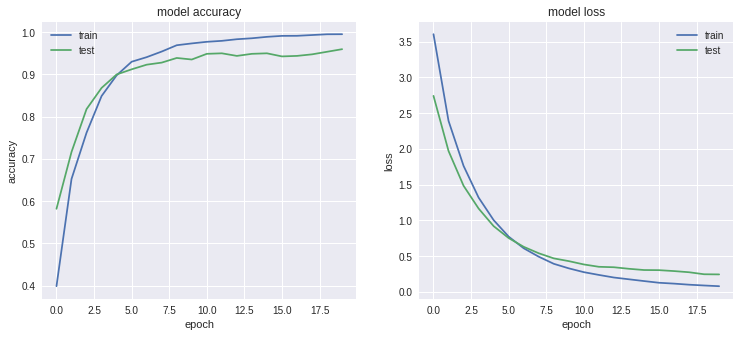

In [0]:
plt.style.use('seaborn')

fig, ax = plt.subplots(1,2)

# summarize history for accuracy
ax[0].plot(hist['train_acc'])
ax[0].plot(hist['val_acc'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax[1].plot(hist['train_loss'])
ax[1].plot(hist['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='upper right')

plt.tight_layout()
plt.subplots_adjust(left=0.3, right=1.5, bottom=0.2, top=0.9, wspace=0.2, hspace=0.2)
plt.show()

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
model.load_state_dict(torch.load('/gdrive/My Drive/pytorch_challenge/model_weights_v2.h5'))
print(model)

In [0]:
model.load_state_dict(torch.load('/gdrive/My Drive/pytorch_challenge/model_weights_v10.h5'))

In [0]:
# Evaluation
correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for inputs, labels in dataloaders['validation']:
        inputs = inputs.cuda().to(device)
        labels = labels.cuda().to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 94 %


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    img_pil = Image.open(image)
   
    adjustments = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img_tensor = adjustments(img_pil)
    
    return img_tensor

In [0]:
!ls flower_data/valid/1

image_06739.jpg  image_06755.jpg  image_06758.jpg  image_06765.jpg
image_06749.jpg  image_06756.jpg  image_06763.jpg  image_06769.jpg


In [0]:
# TODO: Process a PIL image for use in a PyTorch model
img = (data_dir + '/valid/1/image_06756.jpg')
img = process_image(img)
print(img.shape)

torch.Size([3, 224, 224])


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

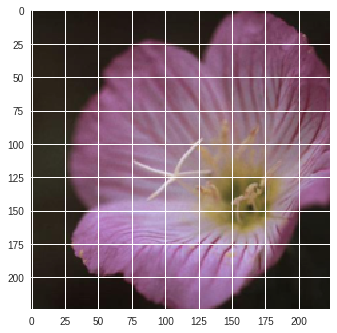

In [0]:
imshow(process_image(valid_dir + '/1/image_06756.jpg'))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
model.class_to_idx = image_datasets['train'].class_to_idx
ctx = model.class_to_idx

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.to('cuda:0')
    img_torch = process_image(image_path)
    img_torch = img_torch.unsqueeze_(0)
    img_torch = img_torch.float()
    
    with torch.no_grad():
        output = model.forward(img_torch.cuda())
        
    probability = F.softmax(output.data,dim=1)
    
    return probability.topk(topk)

In [0]:
!ls flower_data/valid/10/

image_07094.jpg  image_07101.jpg  image_07102.jpg  image_07107.jpg


In [0]:
# TODO: Implement the code to predict the class from an image file
img = (valid_dir + '/10/image_07101.jpg')
val1, val2 = predict(img, model)

print(val1)
print(val2)

tensor([[0.6040, 0.0795, 0.0698, 0.0278, 0.0156]], device='cuda:0')
tensor([[ 1,  6,  8, 48, 93]], device='cuda:0')


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
# TODO: Display an image along with the top 5 classes

def check_sanity(path):
    plt.rcParams["figure.figsize"] = (10,5)
    plt.subplot(211)
    
    index = 1

    probabilities = predict(path, model)
    image = process_image(path)
    probabilities = probabilities
    
    axs = imshow(image, ax = plt)
    axs.axis('off')
    axs.title('Actual Class: ' + cat_to_name[str(index)])
    axs.show()
    
    #Convert probabilities into CPU
    
    a = np.array(probabilities[0][0].cpu())
    b = [cat_to_name[str(index + 1)] for index in np.array(probabilities[1][0].cpu())]
    
    
    N=float(len(b))
    fig,ax = plt.subplots(figsize=(8,3))
    width = 0.8
    tickLocations = np.arange(N)
    ax.bar(tickLocations, a, width, linewidth=4.0, align = 'center')
    ax.set_xticks(ticks = tickLocations)
    ax.set_xticklabels(b)
    ax.set_xlim(min(tickLocations)-0.6,max(tickLocations)+0.6)
    ax.set_yticks([0.2,0.4,0.6,0.8,1,1.2])
    ax.set_ylim((0,1))
    ax.set_title('Predicted Class Probabilities', fontsize=14)
    ax.yaxis.grid(True)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.show()

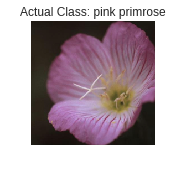

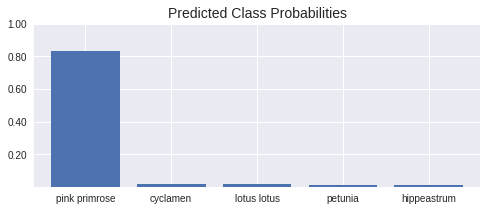

In [0]:
path = valid_dir + '/1/image_06756.jpg'
check_sanity(path)